# XGBoost

Here we will be using XGBoost as a model to predict the subtype of breast cancer. Since XGBoost is a tree-base model, we won't need to scale the data nor do we need to use PCA, since tree models don't need orthogonality. But feature selection would help in avoiding noise and it would make computation much faster.

In [1]:
import pandas as pd

In [2]:
data_df = pd.read_csv("data.csv")

In [3]:
data_df.head()

,RERE,RNF165,PHF7,CIDEA,TENT2,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,...,LATERALITY_Right,LATERALITY_Unknown,HISTOLOGICAL_SUBTYPE_Lobular,HISTOLOGICAL_SUBTYPE_Medullary,HISTOLOGICAL_SUBTYPE_Metaplastic,HISTOLOGICAL_SUBTYPE_Mixed,HISTOLOGICAL_SUBTYPE_Mucinous,HISTOLOGICAL_SUBTYPE_Other,HISTOLOGICAL_SUBTYPE_Tubular/ cribriform,HISTOLOGICAL_SUBTYPE_Unknown
0,8.676978,6.075331,5.838270,6.397503,7.906217,5.702379,6.930741,5.332863,5.275676,5.443896,...,False,False,False,False,False,False,False,False,False,False
1,9.653589,6.687887,5.600876,5.246319,8.267256,5.521794,6.141689,7.563477,5.376381,5.319857,...,False,False,False,False,False,False,False,False,False,False
2,9.033589,5.910885,6.030718,10.111816,7.959291,5.689533,6.529312,5.482155,5.463788,5.254294,...,True,False,False,False,False,False,False,False,False,False
3,8.814855,5.628740,5.849428,6.116868,9.206376,5.439130,6.430102,5.398675,5.409761,5.512298,...,True,False,False,False,False,False,False,False,False,False
4,8.736406,6.392422,5.542133,5.184098,8.162845,5.464326,6.105427,5.026018,5.338580,5.430874,...,True,False,False,False,False,False,False,False,False,False


In [4]:
data_df_processed = data_df.copy()

In [5]:
leakage_cols = [
    "OS_MONTHS",
    "OS_STATUS",
    "RFS_MONTHS",
    "RFS_STATUS"
]

data_df_processed = data_df_processed.drop(columns=leakage_cols)

# Train test split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X = data_df_processed.drop(columns=["CLAUDIN_SUBTYPE"], axis=1)
y = data_df_processed["CLAUDIN_SUBTYPE"]

X, y

(          RERE    RNF165      PHF7      CIDEA     TENT2   SLC17A3       SDS  \
 0     8.676978  6.075331  5.838270   6.397503  7.906217  5.702379  6.930741   
 1     9.653589  6.687887  5.600876   5.246319  8.267256  5.521794  6.141689   
 2     9.033589  5.910885  6.030718  10.111816  7.959291  5.689533  6.529312   
 3     8.814855  5.628740  5.849428   6.116868  9.206376  5.439130  6.430102   
 4     8.736406  6.392422  5.542133   5.184098  8.162845  5.464326  6.105427   
 ...        ...       ...       ...        ...       ...       ...       ...   
 1968  9.606915  7.427494  5.927409   5.927031  8.520545  5.550549  5.841476   
 1969  9.049296  6.850000  6.117095   6.374305  8.499637  5.497546  6.351428   
 1970  8.858622  6.550450  5.936371   5.963092  9.320207  5.690297  7.280037   
 1971  8.415867  6.831722  7.408960   9.181768  6.804085  5.730308  7.642485   
 1972  9.902776  7.338318  5.875759   5.596873  8.436732  5.788639  5.977119   
 
       ATP6V1C2        F3    FAM71C  .

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
label_encode = LabelEncoder()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
y_train_encoded = label_encode.fit_transform(y_train)
y_test_encoded = label_encode.transform(y_test)

In [15]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.3/101.7 MB ? eta -:--:--
   ---------------------------------------- 1.0/101.7 MB 3.1 MB/s eta 0:00:33
    --------------------------------------- 2.1/101.7 MB 4.0 MB/s eta 0:00:26
   - -------------------------------------- 3.7/101.7 MB 5.2 MB/s eta 0:00:20
   - -------------------------------------- 4.7/101.7 MB 5.0 MB/s eta 0:00:20
   -- ------------------------------------- 5.8/101.7 MB 5.0 MB/s eta 0:00:20
   -- ------------------------------------- 6.8/101.7 MB 5.2 MB/s eta 0:00:19
   --- ------------------------------------ 8.1/101.7 MB 5.2 MB/s eta 0:00:18
   --- ------------------------------------ 9.7/101.7 MB 5.7 MB/s eta 0:00:17
   ---- ----------------------------------- 10.7/101.7 MB 5.6 MB/s eta 0:00:17
   ---


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

In [25]:
pipeline = Pipeline([
    ("feature_selection", SelectKBest(score_func=f_classif)),
    ("classifier", XGBClassifier(
        objective="multi:softprob",
        num_class=6,
        eval_metric="mlogloss",
        use_label_encoder=False,
        random_state=42
    ))
])

In [26]:
param_grid = {
    "feature_selection__k": [300, 500, 800],
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [3, 5],
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__subsample": [0.8],
}

In [27]:
from sklearn.model_selection import GridSearchCV

In [29]:
grid.fit(X_train, y_train_encoded)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:59:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,estimator,"Pipeline(step...ass=6, ...))])"
,param_grid,"{'classifier__learning_rate': [0.05, 0.1], 'classifier__max_depth': [3, 5], 'classifier__n_estimators': [100, 200], 'classifier__subsample': [0.8], ...}"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,score_func,<function f_c...00209AE18F7E0>


In [30]:
best_xgb = grid.best_estimator_
print("Best params:")
print(grid.best_params_)

Best params:
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8, 'feature_selection__k': 800}


In [39]:
from sklearn.metrics import classification_report

In [32]:
y_pred = best_xgb.predict(X_test)

In [33]:
print(classification_report(y_test_encoded, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85        42
           1       0.78      0.69      0.73        45
           2       0.79      0.87      0.83       140
           3       0.80      0.87      0.83        95
           4       0.73      0.55      0.63        29
           5       0.91      0.73      0.81        44

    accuracy                           0.81       395
   macro avg       0.81      0.76      0.78       395
weighted avg       0.81      0.81      0.80       395



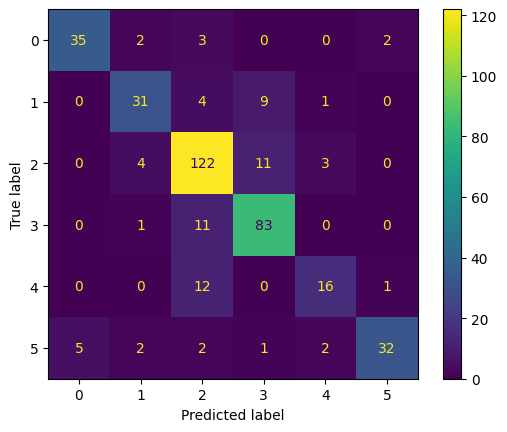

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test)

## Hyperparameter tuning

In [13]:
from sklearn.model_selection import RandomizedSearchCV

In [43]:
pipeline2 = Pipeline([
    ("feature_selection", SelectKBest(score_func=f_classif)),
    ("classifier", XGBClassifier(
        objective="multi:softprob",
        num_class=6,
        eval_metric="mlogloss",
        tree_method="hist",
        device="cuda",
        random_state=42
    ))
])

In [44]:
param2 = {
    "feature_selection__k": [300, 500, 800, 1000],
    "classifier__n_estimators": [200, 300, 400, 500],
    "classifier__max_depth": [3, 4, 5, 6],
    "classifier__learning_rate": [0.01, 0.05, 0.1],
    "classifier__subsample": [0.6, 0.8, 1.0],
    "classifier__gamma": [0, 0.5, 1],
    "classifier__reg_lambda": [1, 5, 10]
}

In [45]:
random_searsh = RandomizedSearchCV(
    pipeline2,
    param_distributions=param2,
    n_iter=50,
    cv=5,
    scoring="f1_weighted",
    n_jobs=1,
    verbose=2,
    random_state=42
)
    

In [46]:
random_searsh.fit(X_train, y_train_encoded)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=500, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=300; total time=  10.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=500, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=300; total time=   9.3s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=500, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=300; total time=   9.6s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=500, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=300; total time=   9.1s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=500, classifier__reg_lam

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.8, feature_selection__k=300; total time=   5.9s
[CV] END classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.8, feature_selection__k=300; total time=   5.6s
[CV] END classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.8, feature_selection__k=300; total time=   5.9s
[CV] END classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.8, feature_selection__k=300; total time=   5.8s
[CV] END classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lam

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=300, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=300; total time=   3.3s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=300, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=300; total time=   3.3s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=300, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=300; total time=   3.3s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=300, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=300; total time=   3.1s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=300, classifier__re

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=800; total time=  18.6s
[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=800; total time=  18.8s
[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=800; total time=  18.8s
[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=800; total time=  18.7s
[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=200, classifier__reg_lam

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=400, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=800; total time=   9.0s
[CV] END classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=400, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=800; total time=  10.1s
[CV] END classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=400, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=800; total time=   9.9s
[CV] END classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=400, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=800; total time=  10.2s
[CV] END classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=400, classifier__reg_lam

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=500, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=300; total time=   5.9s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=500, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=300; total time=   5.8s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=500, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=300; total time=   5.7s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=500, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=300; total time=   5.8s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=500, classifier__re

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=1000; total time=   6.9s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=1000; total time=   6.9s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=1000; total time=   7.1s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=1000; total time=   7.0s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200, classifier__re

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=300, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=1000; total time=   4.9s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=300, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=1000; total time=   5.0s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=300, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=1000; total time=   5.0s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=300, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=1000; total time=   5.1s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=300, classifier__re

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=5, classifier__subsample=1.0, feature_selection__k=800; total time=  11.3s
[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=5, classifier__subsample=1.0, feature_selection__k=800; total time=  11.3s
[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=5, classifier__subsample=1.0, feature_selection__k=800; total time=  11.3s
[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=5, classifier__subsample=1.0, feature_selection__k=800; total time=  11.2s
[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=10, classifier__subsample=0.8, feature_selection__k=500; total time=  13.3s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=10, classifier__subsample=0.8, feature_selection__k=500; total time=  13.3s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=10, classifier__subsample=0.8, feature_selection__k=500; total time=  13.4s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=10, classifier__subsample=0.8, feature_selection__k=500; total time=  14.6s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=1

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=300, classifier__reg_lambda=5, classifier__subsample=0.6, feature_selection__k=500; total time=   7.8s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=300, classifier__reg_lambda=5, classifier__subsample=0.6, feature_selection__k=500; total time=   8.1s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=300, classifier__reg_lambda=5, classifier__subsample=0.6, feature_selection__k=500; total time=   7.9s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=300, classifier__reg_lambda=5, classifier__subsample=0.6, feature_selection__k=500; total time=   8.2s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=300, classifier__reg_lambda=

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.6, feature_selection__k=1000; total time=   8.4s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.6, feature_selection__k=1000; total time=   8.5s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.6, feature_selection__k=1000; total time=   8.8s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.6, feature_selection__k=1000; total time=   8.1s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=400, classifie

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=5, classifier__subsample=1.0, feature_selection__k=500; total time=   5.3s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=5, classifier__subsample=1.0, feature_selection__k=500; total time=   5.4s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=5, classifier__subsample=1.0, feature_selection__k=500; total time=   5.3s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=5, classifier__subsample=1.0, feature_selection__k=500; total time=   5.2s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=500, classifier__r

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=200, classifier__reg_lambda=1, classifier__subsample=1.0, feature_selection__k=1000; total time=   6.3s
[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=200, classifier__reg_lambda=1, classifier__subsample=1.0, feature_selection__k=1000; total time=   6.5s
[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=200, classifier__reg_lambda=1, classifier__subsample=1.0, feature_selection__k=1000; total time=   6.4s
[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=200, classifier__reg_lambda=1, classifier__subsample=1.0, feature_selection__k=1000; total time=   6.4s
[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=200, classifier__reg_lambda=1

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=300; total time=   3.1s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=300; total time=   3.1s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=300; total time=   3.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=300; total time=   2.9s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200, classifier__reg_lambda=1

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.8, feature_selection__k=1000; total time=  12.4s
[CV] END classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.8, feature_selection__k=1000; total time=  12.7s
[CV] END classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.8, feature_selection__k=1000; total time=  12.5s
[CV] END classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.8, feature_selection__k=1000; total time=  12.7s
[CV] END classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lam

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=500; total time=   6.6s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=500; total time=   6.6s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=500; total time=   6.4s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=500; total time=   6.5s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_la

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.6, feature_selection__k=500; total time=   4.7s
[CV] END classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.6, feature_selection__k=500; total time=   4.6s
[CV] END classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.6, feature_selection__k=500; total time=   4.7s
[CV] END classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.6, feature_selection__k=500; total time=   4.8s
[CV] END classifier__gamma=1, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=400, classifier__reg_lambda=

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.8, feature_selection__k=1000; total time=   7.1s
[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.8, feature_selection__k=1000; total time=   6.9s
[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.8, feature_selection__k=1000; total time=   7.2s
[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.8, feature_selection__k=1000; total time=   6.0s
[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=400, classifier__reg_lambda=5

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=300; total time=   2.6s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=300; total time=   2.7s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=300; total time=   2.6s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=300; total time=   2.5s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200, classifier__re

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=300, classifier__reg_lambda=1, classifier__subsample=0.8, feature_selection__k=800; total time=  23.8s
[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=300, classifier__reg_lambda=1, classifier__subsample=0.8, feature_selection__k=800; total time=  23.9s
[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=300, classifier__reg_lambda=1, classifier__subsample=0.8, feature_selection__k=800; total time=  23.9s
[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=300, classifier__reg_lambda=1, classifier__subsample=0.8, feature_selection__k=800; total time=  23.5s
[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=300, classifier__reg_lambda=

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=800; total time=  17.3s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=800; total time=  17.5s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=800; total time=  17.6s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=800; total time=  17.2s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=500, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=800; total time=   9.4s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=500, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=800; total time=   8.8s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=500, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=800; total time=   9.7s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=500, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=800; total time=   9.0s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=500, classifier__r

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.8, feature_selection__k=1000; total time=  15.7s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.8, feature_selection__k=1000; total time=  16.2s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.8, feature_selection__k=1000; total time=  15.7s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.8, feature_selection__k=1000; total time=  15.7s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=200, class

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=200, classifier__reg_lambda=1, classifier__subsample=1.0, feature_selection__k=1000; total time=  10.8s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=200, classifier__reg_lambda=1, classifier__subsample=1.0, feature_selection__k=1000; total time=  11.0s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=200, classifier__reg_lambda=1, classifier__subsample=1.0, feature_selection__k=1000; total time=  10.9s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=200, classifier__reg_lambda=1, classifier__subsample=1.0, feature_selection__k=1000; total time=  10.6s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=200, classifie

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=500, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=1000; total time=  21.2s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=500, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=1000; total time=  20.9s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=500, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=1000; total time=  20.9s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=500, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=1000; total time=  20.9s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=500, classifier__reg_lam

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=400, classifier__reg_lambda=1, classifier__subsample=0.8, feature_selection__k=800; total time=   8.9s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=400, classifier__reg_lambda=1, classifier__subsample=0.8, feature_selection__k=800; total time=   8.9s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=400, classifier__reg_lambda=1, classifier__subsample=0.8, feature_selection__k=800; total time=   8.9s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=400, classifier__reg_lambda=1, classifier__subsample=0.8, feature_selection__k=800; total time=   8.9s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=400, classifier__r

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=300, classifier__reg_lambda=1, classifier__subsample=1.0, feature_selection__k=500; total time=   8.7s
[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=300, classifier__reg_lambda=1, classifier__subsample=1.0, feature_selection__k=500; total time=   8.6s
[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=300, classifier__reg_lambda=1, classifier__subsample=1.0, feature_selection__k=500; total time=   8.6s
[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=300, classifier__reg_lambda=1, classifier__subsample=1.0, feature_selection__k=500; total time=   8.6s
[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=300, classifier__reg_lambda=

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=500, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=800; total time=  11.3s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=500, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=800; total time=  12.9s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=500, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=800; total time=  13.0s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=500, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=800; total time=  13.1s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=500, classifie

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=5, classifier__subsample=0.8, feature_selection__k=500; total time=   4.8s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=5, classifier__subsample=0.8, feature_selection__k=500; total time=   4.6s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=5, classifier__subsample=0.8, feature_selection__k=500; total time=   4.7s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=5, classifier__subsample=0.8, feature_selection__k=500; total time=   4.5s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_la

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=300, classifier__reg_lambda=5, classifier__subsample=0.6, feature_selection__k=800; total time=   4.3s
[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=300, classifier__reg_lambda=5, classifier__subsample=0.6, feature_selection__k=800; total time=   4.1s
[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=300, classifier__reg_lambda=5, classifier__subsample=0.6, feature_selection__k=800; total time=   4.4s
[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=300, classifier__reg_lambda=5, classifier__subsample=0.6, feature_selection__k=800; total time=   4.1s
[CV] END classifier__gamma=1, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=300, classifier__reg_lambda=5, cl

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=1000; total time=   9.8s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=1000; total time=  10.1s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=1000; total time=  10.1s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=1000; total time=   9.9s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=200, class

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=1, classifier__subsample=0.8, feature_selection__k=1000; total time=   9.5s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=1, classifier__subsample=0.8, feature_selection__k=1000; total time=   9.4s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=1, classifier__subsample=0.8, feature_selection__k=1000; total time=   9.5s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=1, classifier__subsample=0.8, feature_selection__k=1000; total time=   9.1s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=1

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.8, feature_selection__k=300; total time=   8.2s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.8, feature_selection__k=300; total time=   8.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.8, feature_selection__k=300; total time=   8.5s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.8, feature_selection__k=300; total time=   7.9s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=400, classifier__reg_lambda=5, cl

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=800; total time=   6.5s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=800; total time=   6.3s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=800; total time=   6.3s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=800; total time=   6.3s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200, classifier__re

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=400, classifier__reg_lambda=10, classifier__subsample=0.8, feature_selection__k=300; total time=   5.4s
[CV] END classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=400, classifier__reg_lambda=10, classifier__subsample=0.8, feature_selection__k=300; total time=   5.2s
[CV] END classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=400, classifier__reg_lambda=10, classifier__subsample=0.8, feature_selection__k=300; total time=   5.2s
[CV] END classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=400, classifier__reg_lambda=10, classifier__subsample=0.8, feature_selection__k=300; total time=   5.4s
[CV] END classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=400, classifier__reg_lam

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=200, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=800; total time=  13.1s
[CV] END classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=200, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=800; total time=  13.4s
[CV] END classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=200, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=800; total time=  13.4s
[CV] END classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=200, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=800; total time=  13.2s
[CV] END classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=200, classifier__reg_lambda=

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=300, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=800; total time=   6.9s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=300, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=800; total time=   6.8s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=300, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=800; total time=   7.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=300, classifier__reg_lambda=10, classifier__subsample=1.0, feature_selection__k=800; total time=   6.9s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=300, classifier__reg_lam

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200, classifier__reg_lambda=1, classifier__subsample=1.0, feature_selection__k=300; total time=   2.3s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200, classifier__reg_lambda=1, classifier__subsample=1.0, feature_selection__k=300; total time=   2.3s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200, classifier__reg_lambda=1, classifier__subsample=1.0, feature_selection__k=300; total time=   2.1s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200, classifier__reg_lambda=1, classifier__subsample=1.0, feature_selection__k=300; total time=   2.2s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200, classifier__reg_la

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=5, classifier__subsample=1.0, feature_selection__k=1000; total time=   7.9s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=5, classifier__subsample=1.0, feature_selection__k=1000; total time=   7.8s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=5, classifier__subsample=1.0, feature_selection__k=1000; total time=   7.9s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=500, classifier__reg_lambda=5, classifier__subsample=1.0, feature_selection__k=1000; total time=   7.9s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=500, classifie

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=300; total time=   2.9s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=300; total time=   3.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=300; total time=   2.9s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=300; total time=   3.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200, classifier__reg_lam

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=300, classifier__reg_lambda=5, classifier__subsample=1.0, feature_selection__k=1000; total time=   6.7s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=300, classifier__reg_lambda=5, classifier__subsample=1.0, feature_selection__k=1000; total time=   6.5s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=300, classifier__reg_lambda=5, classifier__subsample=1.0, feature_selection__k=1000; total time=   6.5s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=300, classifier__reg_lambda=5, classifier__subsample=1.0, feature_selection__k=1000; total time=   6.5s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=300, classifie

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=300, classifier__reg_lambda=1, classifier__subsample=1.0, feature_selection__k=500; total time=  13.1s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=300, classifier__reg_lambda=1, classifier__subsample=1.0, feature_selection__k=500; total time=  13.2s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=300, classifier__reg_lambda=1, classifier__subsample=1.0, feature_selection__k=500; total time=  13.1s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=300, classifier__reg_lambda=1, classifier__subsample=1.0, feature_selection__k=500; total time=  13.1s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=300, classifier__r

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=400, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=500; total time=  11.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=400, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=500; total time=  11.7s
[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=400, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=500; total time=  11.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=400, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=500; total time=  11.3s
[CV] END classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=400, classifier__reg_lam

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=500; total time=   8.5s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=500; total time=   8.5s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=500; total time=   8.5s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=10, classifier__subsample=0.6, feature_selection__k=500; total time=   8.5s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=200, classifie

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.8, feature_selection__k=300; total time=   6.5s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.8, feature_selection__k=300; total time=   6.7s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.8, feature_selection__k=300; total time=   6.6s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=400, classifier__reg_lambda=5, classifier__subsample=0.8, feature_selection__k=300; total time=   6.4s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=400, classifier__r

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=5, classifier__subsample=1.0, feature_selection__k=300; total time=   4.7s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=5, classifier__subsample=1.0, feature_selection__k=300; total time=   4.9s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=5, classifier__subsample=1.0, feature_selection__k=300; total time=   5.0s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=200, classifier__reg_lambda=5, classifier__subsample=1.0, feature_selection__k=300; total time=   4.8s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=200, classifier__r

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=300, classifier__reg_lambda=10, classifier__subsample=0.8, feature_selection__k=1000; total time=  12.1s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=300, classifier__reg_lambda=10, classifier__subsample=0.8, feature_selection__k=1000; total time=  12.2s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=300, classifier__reg_lambda=10, classifier__subsample=0.8, feature_selection__k=1000; total time=  12.2s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=300, classifier__reg_lambda=10, classifier__subsample=0.8, feature_selection__k=1000; total time=  12.0s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=300, classifier__reg_lamb

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=300, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=800; total time=  10.1s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=300, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=800; total time=  10.3s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=300, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=800; total time=  10.1s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=300, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=800; total time=  10.1s
[CV] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=300, classifier__reg_lambda=1, cl

C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [20630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\marij\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=500, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=300; total time=   5.1s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=500, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=300; total time=   5.8s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=500, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=300; total time=   5.4s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=500, classifier__reg_lambda=1, classifier__subsample=0.6, feature_selection__k=300; total time=   4.7s
[CV] END classifier__gamma=0.5, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=500, classifier__r

,estimator,"Pipeline(step...ass=6, ...))])"
,param_distributions,"{'classifier__gamma': [0, 0.5, ...], 'classifier__learning_rate': [0.01, 0.05, ...], 'classifier__max_depth': [3, 4, ...], 'classifier__n_estimators': [200, 300, ...], ...}"
,n_iter,50
,scoring,'f1_weighted'
,n_jobs,1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [47]:
best_model = random_searsh.best_estimator_

In [48]:
print("Best params: ")
print(random_searsh.best_params_)

Best params: 
{'feature_selection__k': 800, 'classifier__subsample': 0.6, 'classifier__reg_lambda': 1, 'classifier__n_estimators': 500, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.05, 'classifier__gamma': 0.5}


In [49]:
y_pred2 = best_model.predict(X_test)

In [50]:
print(classification_report(y_test_encoded, y_pred2))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85        42
           1       0.74      0.69      0.71        45
           2       0.81      0.88      0.85       140
           3       0.82      0.88      0.85        95
           4       0.74      0.59      0.65        29
           5       0.89      0.73      0.80        44

    accuracy                           0.82       395
   macro avg       0.81      0.77      0.79       395
weighted avg       0.82      0.82      0.81       395



In [51]:
xgb_model = best_model.named_steps["classifier"]

In [52]:
mask = best_model.named_steps["feature_selection"].get_support()
selected_features = X.columns[mask]

In [54]:
importances = xgb_model.feature_importances_
xgb_importance_df = pd.DataFrame({
    "Gene": selected_features,
    "Importance" : importances
}).sort_values(by="Importance", ascending=False)

top_50 = xgb_importance_df.head(50)

In [55]:
top_50

,Gene,Importance
799,INTCLUST_10,0.039699
566,CCNB2,0.025433
46,SLC9A9,0.016126
178,HCST,0.012809
295,DSC2,0.010602
278,CENPA,0.010434
362,SH3KBP1,0.010220
224,BUB1,0.010137
785,CEP55,0.009502
796,DOCK11,0.008088


How many “hits” did XGBoost get from PAM50?
Here are the ones that are in my top list:

Proliferation block (Tumor Engine): This is the strongest part of my model.
CCNB2, CENPA, CEP55, BUB1, SKP2, MELK, CDK1, PTTG1, AURKB, CDKN3, DLGAP5.

Why is this important? These are all in PAM50. They are key to separating Luminal A (slow dividing) from Luminal B and Basal (fast dividing).
Luminal markers (ER+ signature):
GATA3, FOXA1, ESR1. These are the “holy three” for defining hormone-dependent cancer.
HER2 block:
ERBB2 (the HER2 gene itself) and GRB7. Those two genes always go together in PAM50 to identify the HER2-enriched subtype.
Basal markers:
KRT5, EGFR, SFRP1.

Conclusion: My XGBoost model in the top 50 list contains almost 50% of the PAM50 genes! This is a scientifically very strong result.

What is "INTCLUST_10"?

Note the first place: INTCLUST_10. This is not a regular gene, but probably a meta-data or classification from the METABRIC dataset (Integrative Cluster 10).

Why is it first? Integrative cluster 10 is synonymous with the Basal-like subtype with a very poor prognosis. XGBoost immediately realized that if this marker is present, the sample is 100% Basal.

Comparison: Logistic Regression vs. XGBoost

It’s interesting how both models look at the problem:
Feature Logistic Regression (My frist baseline model) XGBoost (The new one)
Focus Structural genes (KRT17, KRT14) Cycle controllers (CCNB2, BUB1)
Style “What is this cell?” (Keratins) “How fast is this cell dividing?”
Accuracy 0.81 0.82

XGBoost is more accurate because it looks at interactions. For example, it sees that MAD2L1 and CDK1 together are much stronger evidence of aggressive cancer than either gene alone.

Interesting observation I found:
I have a few genes that are not in PAM50, but are cutting-edge science:
GZMB (Granzyme B): This is a marker of immune response. If it’s high, it means the immune system is attacking the tumor (often in Basal and HER2).
PSAT1: This gene is related to metabolism and is often a marker of poor response to therapy in ER+ patients.